In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d as spline

import TwoPUtils as tpu

%matplotlib inline

In [2]:
rng = np.random.default_rng()



In [153]:
class KWTA():
    
    def __init__(self,n_pos = 30, w_max=100, n_ca3=1000, n_ca1 = 1000, n_winners = 100, 
                 eta=1E-4, tau=1E-5, eta_ctrl = None, max_pos = 10, ca3_sigma_mag = .08,
                weight_dist='lognormal', w_sigma_mag = 1E-3,w_norm_decay=1E-3, ca1_noise = 1):
        
        self.n_pos = n_pos
        self.pos = np.linspace(0,10,num=n_pos)[np.newaxis,:]
        self.max_pos = max_pos
        self.w_max = w_max
        self.n_ca3 = n_ca3
        self.n_ca1 = n_ca1
        self.n_winners = n_winners
        self.eta = eta
        self.tau = tau
        self.ca3_sigma_mag = ca3_sigma_mag
        self.w_sigma_mag = w_sigma_mag
        self.w_norm_decay = w_norm_decay
        self.ca1_noise = ca1_noise
        
        
        self.mu = np.linspace(0,self.max_pos,num=n_ca3)[:,np.newaxis]
        self.ca3  = tpu.utilities.gaussian(self.mu,.5,self.pos) # cells by postions
        
        if weight_dist == 'uniform':
            self.w = rng.random(size=[n_ca1,n_ca3]) #
        elif weight_dist == 'lognormal':
            self.w = rng.lognormal(sigma=.5, size= [n_ca1,n_ca3])
        else:
            pass
        
        if eta_ctrl is not None:
            ctrl_x = np.linspace(0,10,num=np.array(eta_ctrl).shape[0])
            self.eta_gain = spline(ctrl_x,eta_ctrl)
            self.eta_gain_mat = np.eye(n_pos)*self.eta_gain(self.pos).T
        else:
            self.eta_gain_mat = np.eye(n_pos)
            
        
    
    def winners(self):
        ca1 = np.zeros([self.n_ca1,self.n_pos])
        activations = np.matmul(self.w,self.ca3+self.ca3_sigma_mag*rng.standard_normal(size=[self.n_ca3,self.n_pos])) 
        winners = np.argsort(activations,axis=0)[::-1,:]
        for pos_ind in range(self.n_pos):
            ca1[winners[:self.n_winners,pos_ind],pos_ind]=activations[winners[:self.n_winners,pos_ind],pos_ind]
            ca1 += self.ca1_noise*rng.random(size=[self.n_ca1, self.n_pos])
            ca1 = np.maximum(0, ca1)
        return ca1
        
    def forward(self):
        ca1 = self.winners()
        self.w += self.eta*np.matmul(np.matmul(ca1,self.eta_gain_mat),self.ca3.T) - self.tau + self.w_sigma_mag*rng.standard_normal(size=self.w.shape)
        self.w -= self.w_norm_decay*np.linalg.norm(self.w,axis=-1,keepdims=True)
        self.w = np.minimum(np.maximum(self.w,0),self.w_max)
        return ca1
    
    def oja(self):
        
        ca1 = self.winners()
        self.w += self.eta*(np.matmul(np.matmul(ca1,self.eta_gain_mat),self.ca3.T) - np.matmul(np.power(ca1,2),self.ca3.T))
        self.w = np.minimum(np.maximum(self.w,0),self.w_max)
        return ca1

(100, 1000, 30)

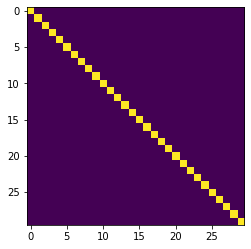

In [154]:
# no learning

nl_kwta = KWTA(eta = 0, tau=0,w_norm_decay=0)
fig,ax = plt.subplots()
ax.imshow(nl_kwta.eta_gain_mat)
nl_ca1 = []
for trial in range(100):
    nl_ca1.append(nl_kwta.forward())
nl_ca1 = np.array(nl_ca1)
nl_ca1.shape

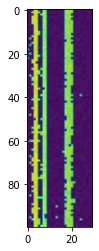

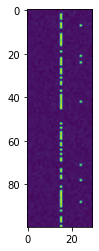

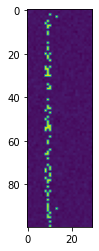

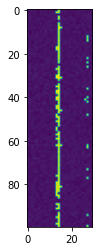

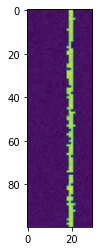

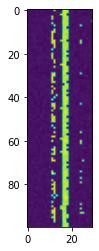

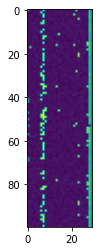

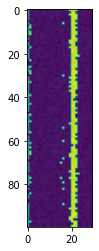

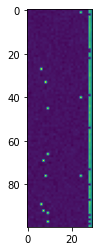

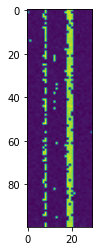

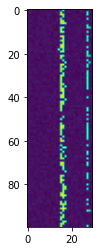

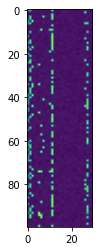

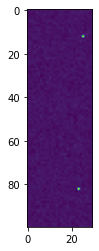

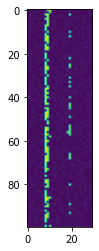

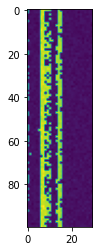

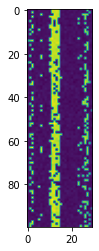

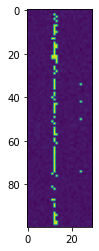

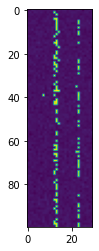

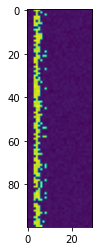

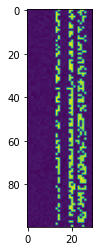

In [155]:
#rate map for a cell

for i in range(20):
    fig, ax = plt.subplots()
    ax.imshow(nl_ca1[:,i,:])

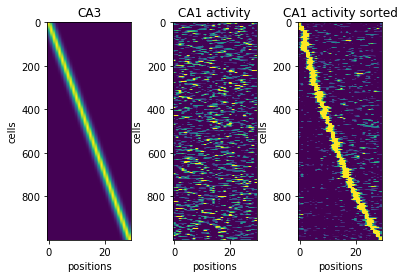

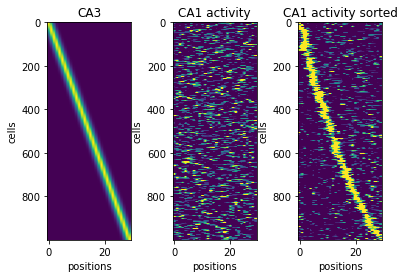

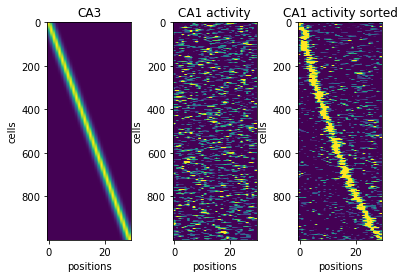

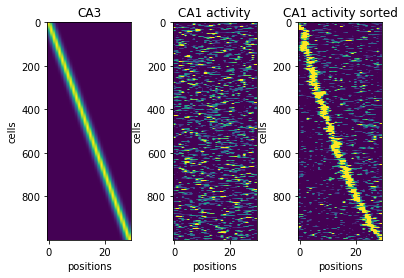

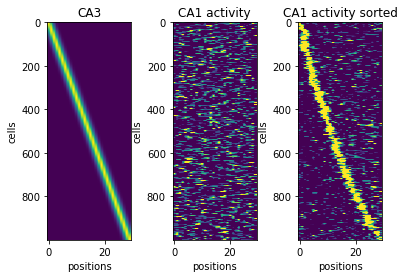

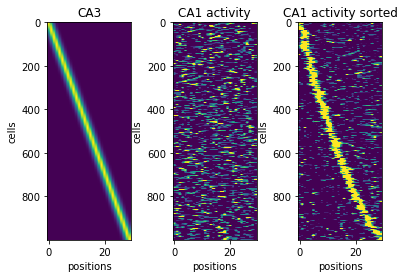

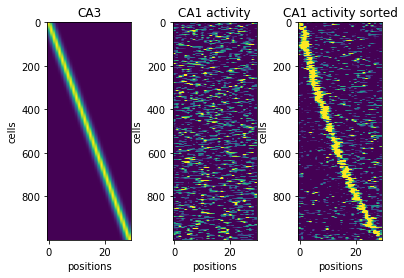

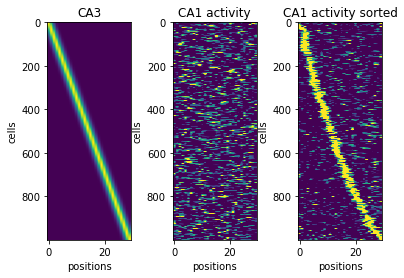

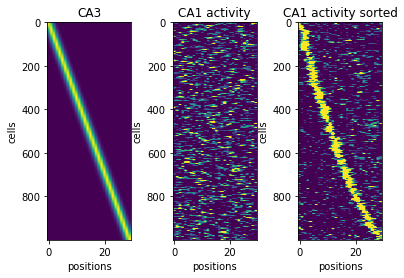

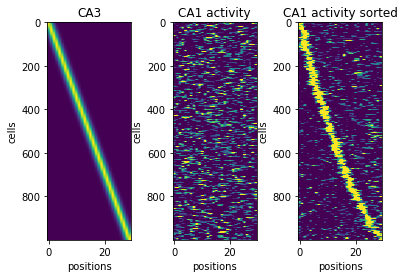

In [156]:

for trial in range(0,10):
    fig,ax = plt.subplots(1,3)
    fig.subplots_adjust(wspace= .5)
    nl_ca1_z = (nl_ca1-nl_ca1.mean(axis=-1,keepdims=True))/(np.std(nl_ca1,axis=-1,keepdims=True)+1E-3)
    ax[0].imshow(nl_kwta.ca3, vmin=0,vmax=1, aspect='auto')
    ax[0].set_title('CA3')

    ax[1].imshow(nl_ca1_z[trial,:,:], vmin=0,vmax=1, aspect='auto')
    
    if trial == 0:
        ca1_sort = np.argsort(np.argmax(nl_ca1[trial,:,:],axis=-1))
    ax[2].imshow(nl_ca1_z[trial, ca1_sort,:], vmin=0,vmax=1,aspect='auto')

    ax[1].set_title('CA1 activity')
    ax[2].set_title('CA1 activity sorted')

    for i in range(3):
        ax[i].set_ylabel('cells')
        ax[i].set_xlabel('positions')


(100, 1000, 30)

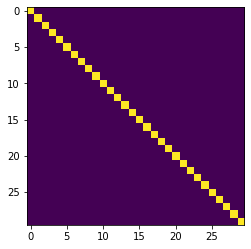

In [157]:
l_kwta = KWTA(eta = 1E-4, tau=0, w_norm_decay=1E-4)
fig,ax = plt.subplots()
ax.imshow(l_kwta.eta_gain_mat)
l_ca1 = []
for trial in range(100):
    l_ca1.append(l_kwta.forward())
#     l_ca1.append(l_kwta.oja())
l_ca1 = np.array(l_ca1)
l_ca1.shape

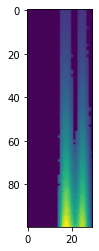

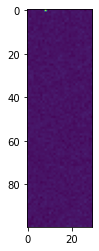

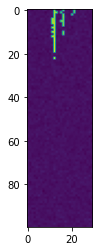

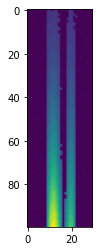

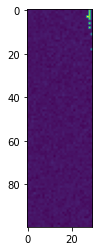

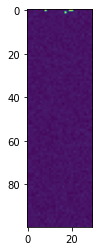

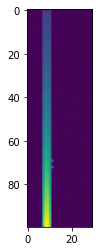

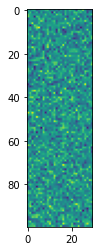

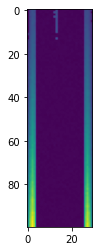

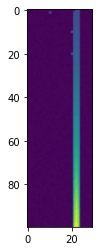

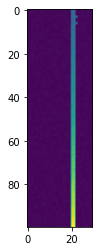

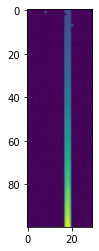

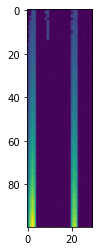

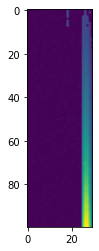

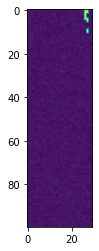

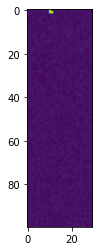

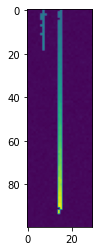

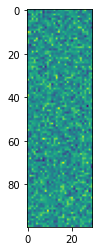

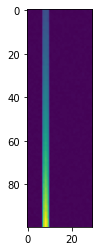

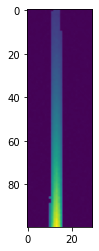

In [158]:
for i in range(20):
    fig, ax = plt.subplots()
    ax.imshow(l_ca1[:,i,:])

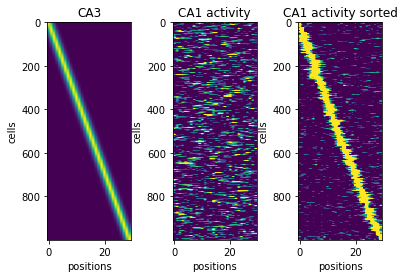

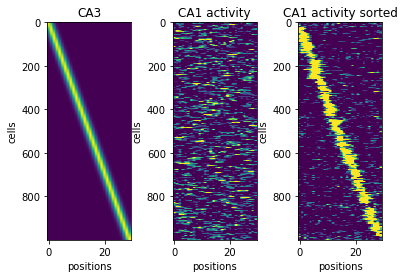

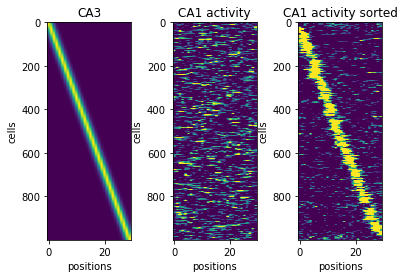

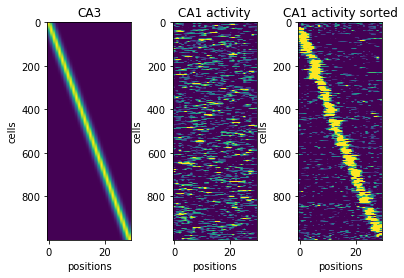

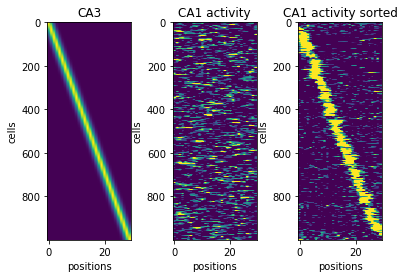

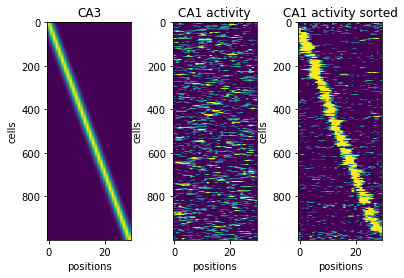

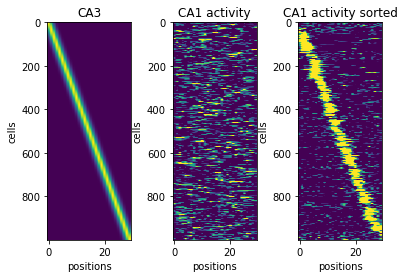

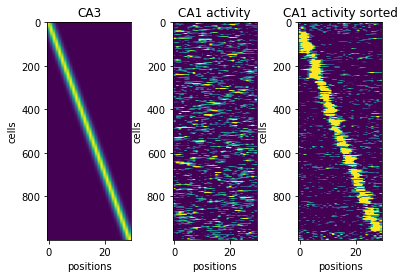

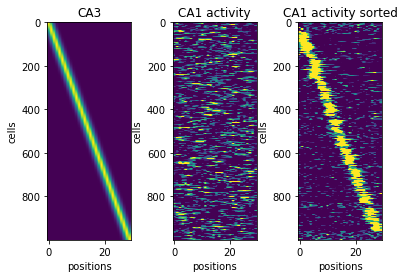

In [159]:
for trial in range(10,100, 10):
    fig,ax = plt.subplots(1,3)
    fig.subplots_adjust(wspace= .5)
    l_ca1_z = (l_ca1-l_ca1.mean(axis=-1,keepdims=True))/(np.std(l_ca1,axis=-1,keepdims=True)+1E-3)
    ax[0].imshow(l_kwta.ca3, vmin=0,vmax=1, aspect='auto')
    ax[0].set_title('CA3')

    ax[1].imshow(l_ca1_z[trial,:,:], vmin=0,vmax=1, aspect='auto')
    
    if trial == 10:
        ca1_sort = np.argsort(np.argmax(l_ca1[trial,:,:],axis=-1))
    ax[2].imshow(l_ca1_z[trial, ca1_sort,:], vmin=0,vmax=1,aspect='auto')

    ax[1].set_title('CA1 activity')
    ax[2].set_title('CA1 activity sorted')

    for i in range(3):
        ax[i].set_ylabel('cells')
        ax[i].set_xlabel('positions')


In [160]:
def field_width(trial_mat):
    maxnorm = trial_mat.mean(axis=0)
    _max, _min = np.amax(maxnorm,axis=0,keepdims=True), np.amin(maxnorm,axis=0,keepdims=True)
    maxnorm = (maxnorm-_min)/(_max-_min +1E-5)
    maxinds = np.argmax(maxnorm,axis=0)

    half_mask = maxnorm<=.5
    fw = []
    for cell in range(maxnorm.shape[1]):
        l = np.argwhere(half_mask[:maxinds[cell],cell])
        r = np.argwhere(half_mask[maxinds[cell]:,cell])
        if l.shape[0]>0 and r.shape[0]>0:  
            ledge, redge = l[-1][0], r[0][0]+ maxinds[cell]
            fw.append(redge-ledge)
    return np.array(fw)

def max_counts(trial_mat):
    
    tmp_mat = trial_mat.mean(axis=0)
    tmp_mat /= tmp_mat.mean(axis=1,keepdims=True)
    max_counts = []
    for cell in range(tmp_mat.shape[-1]):
        extm,_ = sp.signal.find_peaks(tmp_mat[:,cell],height=1)
        max_counts.append(extm.shape[0])
    
    return np.array(max_counts)

def spatial_std(avg_trial_mat):
    avg_trial_mat_norm = avg_trial_mat/(np.nansum(avg_trial_mat, axis=0,keepdims=True)+1E-5)
    inds = np.arange(0,avg_trial_mat.shape[0])[:, np.newaxis]
    
    com = (avg_trial_mat_norm*inds).sum(axis=0,keepdims=True)
    std = np.power((np.power(inds - com,2)*avg_trial_mat_norm).sum(axis=0),.5)
    return std.ravel()


    

In [173]:
nl_trial_mat = np.transpose(nl_ca1,axes=(0,2,1))
l_trial_mat = np.transpose(l_ca1,axes=(0,2,1))
print(nl_trial_mat.shape)


(100, 30, 1000)


In [185]:
occ = np.ones([30,])/30
nl_si = tpu.spatial_analyses.spatial_info(nl_trial_mat.mean(axis=0),occ)
l_si = tpu.spatial_analyses.spatial_info(l_trial_mat.mean(axis=0),occ)

(array([  6.,  16.,  23.,  61., 133., 220., 229., 164.,  73.,  15.]),
 array([0.14748498, 0.42575171, 0.70401845, 0.98228518, 1.26055192,
        1.53881865, 1.81708539, 2.09535212, 2.37361886, 2.65188559,
        2.93015233]),
 <BarContainer object of 10 artists>)

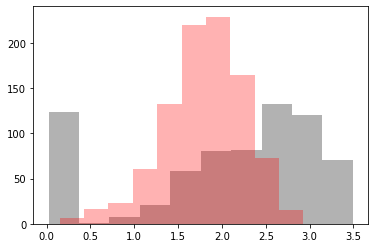

In [186]:
fig,ax = plt.subplots()
ax.hist(l_si, color='black', alpha=.3)
ax.hist(nl_si, color='red', alpha=.3)

In [187]:
l_mask = l_si>.5
nl_mask = nl_si>.5

l_trial_mat = l_trial_mat[:,:,l_mask]
l_trial_mat = l_trial_mat[-100:,:,:]
nl_trial_mat = nl_trial_mat[:,:,nl_mask]
nl_trial_mat = nl_trial_mat[-100:,:,:]

In [188]:
l_std = spatial_std(l_trial_mat.mean(axis=0))
nl_std = spatial_std(nl_trial_mat.mean(axis=0))

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00875657,
        0.03502627, 0.07005254, 0.11383538, 0.17688266, 0.24343257,
        0.30998249, 0.3642732 , 0.42031524, 0.46234676, 0.51838879,
        0.59019264, 0.64448336, 0.70402802, 0.74255692, 0.77232925,
        0.81085814, 0.83537653, 0.84763573, 0.86164623, 0.86690018,
        0.90192644, 0.93870403, 0.94570928, 0.9614711 , 0.97022767,
        0.9737303 , 0.97898424, 0.98423818, 0.98949212, 0.99299475,
        0.99299475, 0.99474606, 0.99824869, 1.        ]),
 array([ 0.        ,  0.24489796,  0.48979592,  0.73469388,  0.97959184,
         1.2244898 ,  1.46938776,  1.71428571,  1.95918367,  2.20408163,
         2.44897959,  2.69387755,  2.93877551,  3.18367347,  3.42857143,
         3.67346939,  3.91836735,  4.16326531,  4.40816327,  4.65306122,
         4.89795918,  5.14285714,  5.3

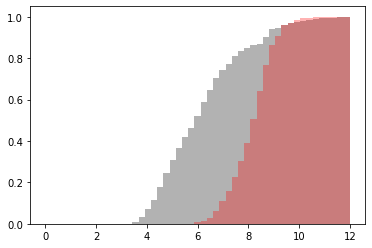

In [189]:
fig,ax = plt.subplots()
bins = np.linspace(0,12)
ax.hist(nl_std, bins = bins, color='red', alpha=.3,density=True, cumulative= True)
ax.hist(l_std,bins=bins, color='black', alpha=.3, zorder=-1,density=True, cumulative=True)

In [190]:
nl_fw = field_width(nl_trial_mat)
l_fw = field_width(l_trial_mat)

(array([0.        , 0.        , 0.        , 0.14877589, 0.25800377,
        0.22033898, 0.13559322, 0.10922787, 0.05084746, 0.02636535,
        0.01694915, 0.01506591, 0.00376648, 0.00376648, 0.0094162 ,
        0.00188324, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

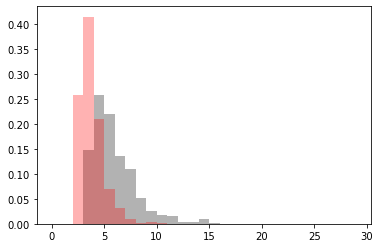

In [191]:
bins = np.arange(0,30)
fig,ax = plt.subplots()
ax.hist(nl_fw, bins = bins, color='red', alpha=.3,density=True)
ax.hist(l_fw,bins=bins, color='black', alpha=.3, zorder=-1,density=True)

In [192]:
l_peaks = max_counts(l_trial_mat)
nl_peaks = max_counts(nl_trial_mat)

(array([0.77005348, 0.21568627, 0.01426025, 0.        , 0.        ]),
 array([1, 2, 3, 4, 5, 6]),
 <BarContainer object of 5 artists>)

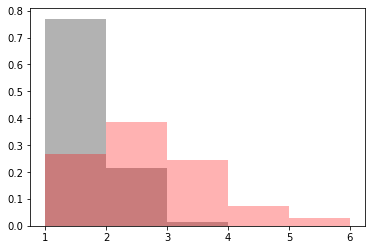

In [193]:
bins = np.arange(1,7)
fig,ax = plt.subplots()
ax.hist(nl_peaks, bins = bins, color='red', alpha=.3,density=True)
ax.hist(l_peaks,bins=bins, color='black', alpha=.3, zorder=-1,density=True)

(20, 1000, 30)

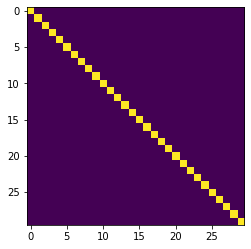

In [60]:
da_kwta = KWTA(eta = 1E-2, tau=0,w_norm_decay=1E-3, eta_ctrl = [.1, .1, .1, .3, .5, .2, .1, .1, .1 ,.1])
fig,ax = plt.subplots()
ax.imshow(l_kwta.eta_gain_mat)
da_ca1 = []
for trial in range(20):
    da_ca1.append(da_kwta.forward())
da_ca1 = np.array(da_ca1)
da_ca1.shape

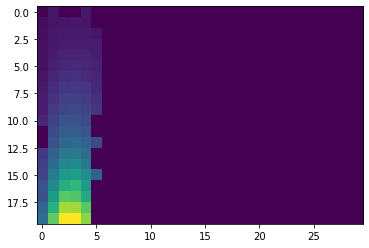

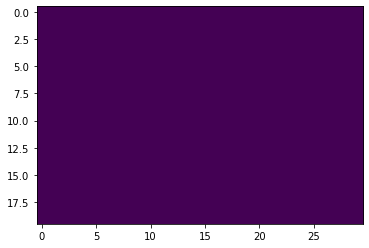

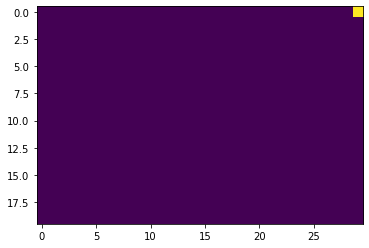

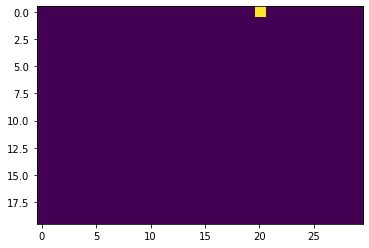

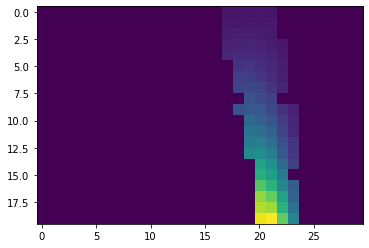

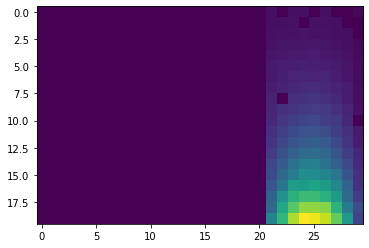

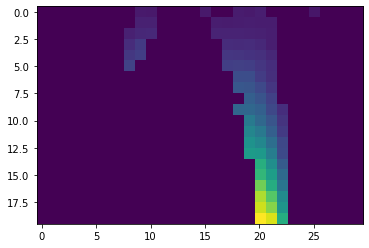

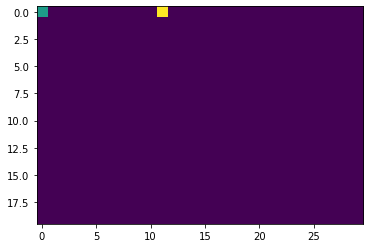

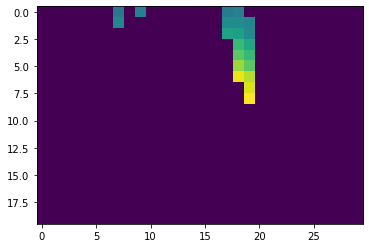

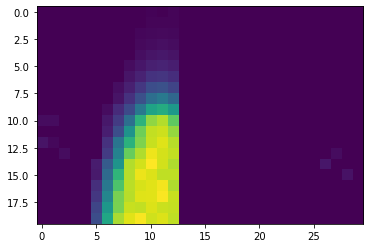

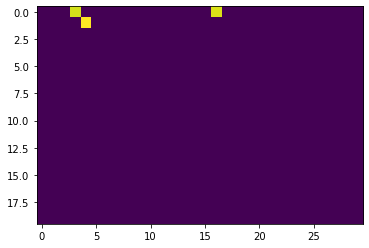

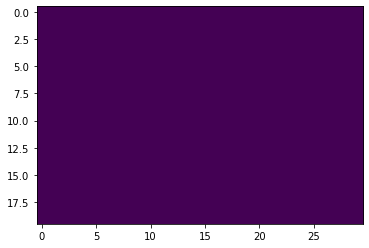

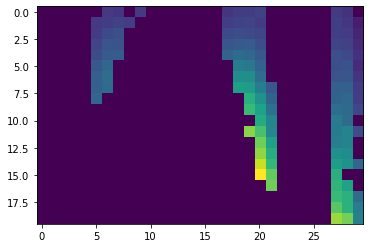

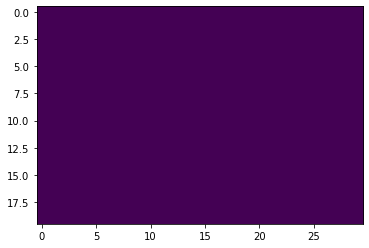

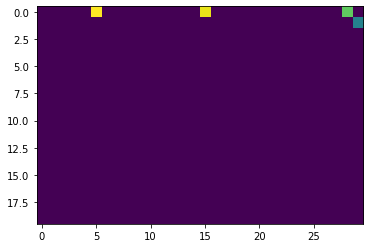

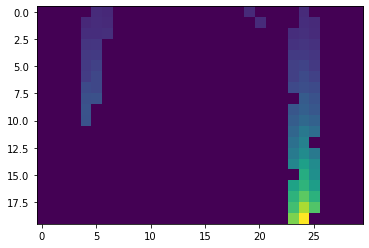

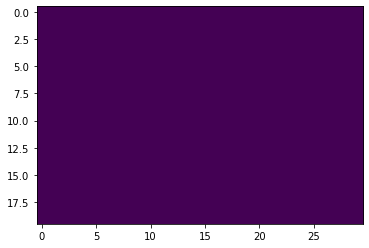

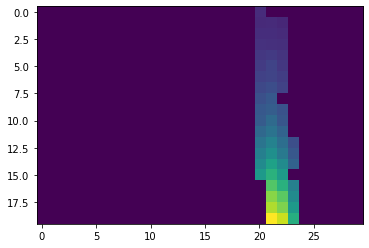

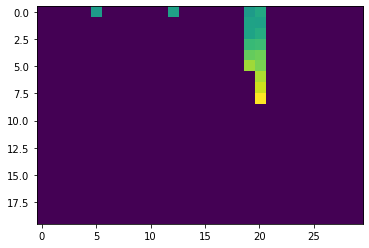

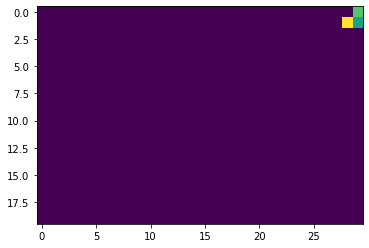

In [61]:
for i in range(20):
    fig, ax = plt.subplots()
    ax.imshow(da_ca1[:,i,:])

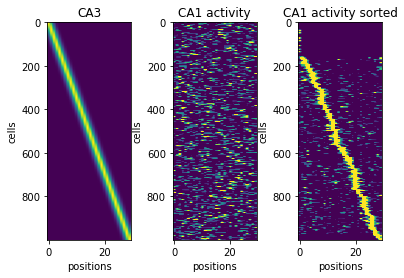

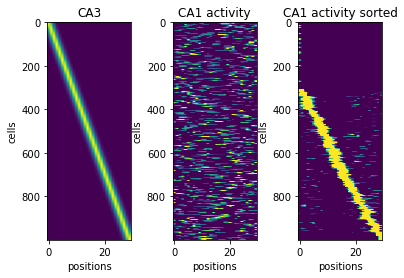

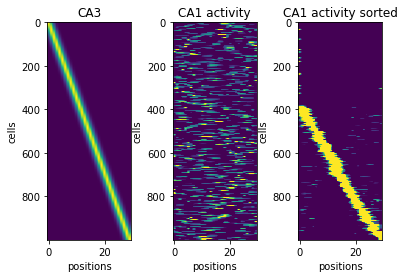

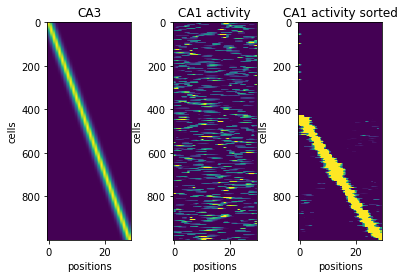

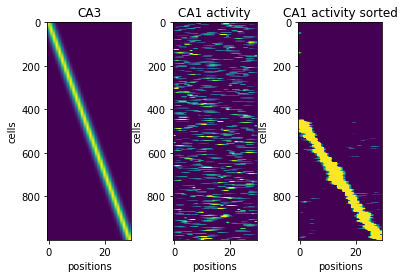

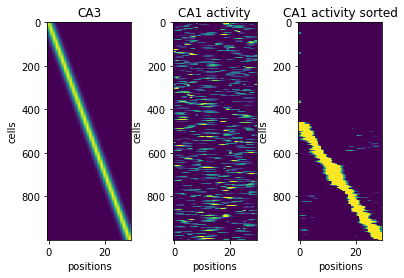

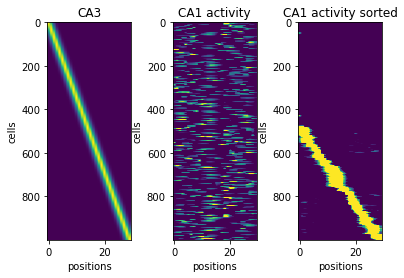

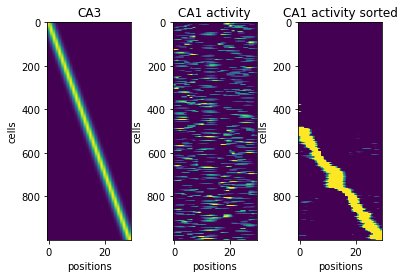

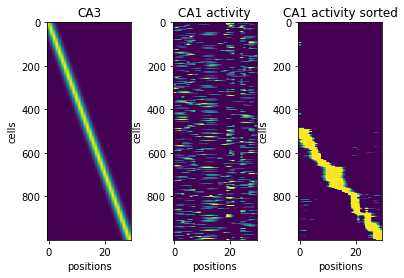

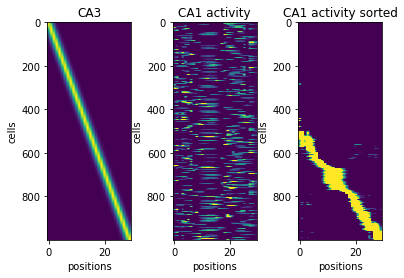

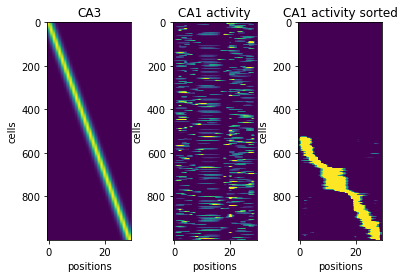

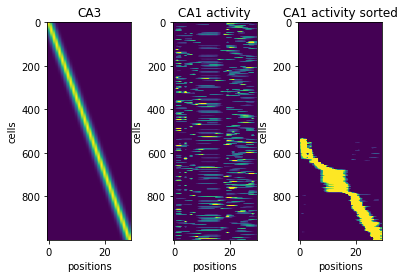

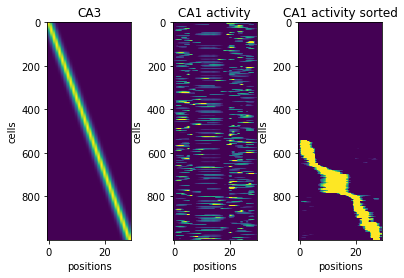

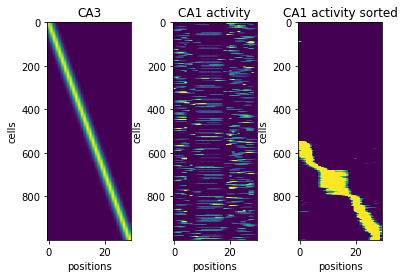

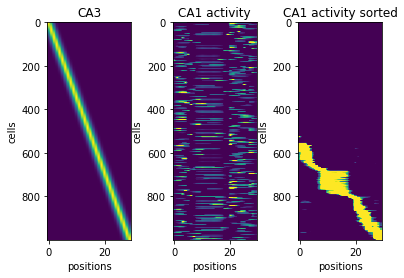

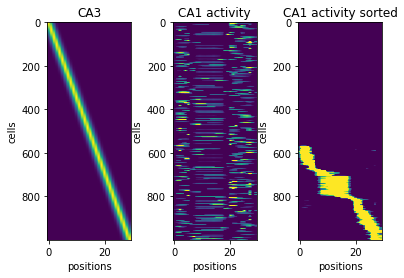

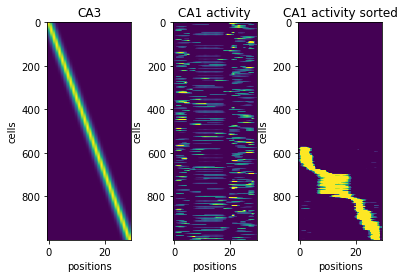

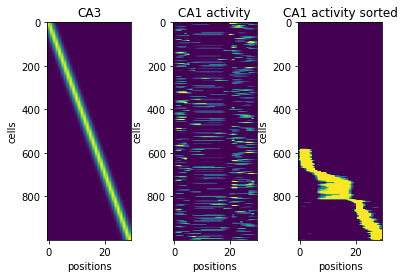

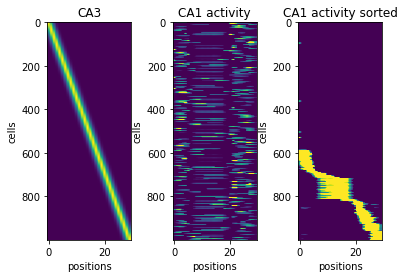

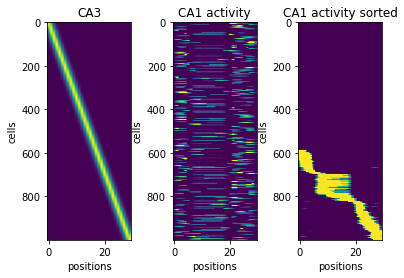

In [62]:
for trial in range(0,20):
    fig,ax = plt.subplots(1,3)
    fig.subplots_adjust(wspace= .5)
    da_ca1_z = (da_ca1-da_ca1.mean(axis=-1,keepdims=True))/(np.std(da_ca1,axis=-1,keepdims=True)+1E-3)
    ax[0].imshow(da_kwta.ca3, vmin=0,vmax=1, aspect='auto')
    ax[0].set_title('CA3')

    ax[1].imshow(da_ca1_z[trial,:,:], vmin=0,vmax=1, aspect='auto')
    
#     if trial == 0:
    ca1_sort = np.argsort(np.argmax(da_ca1[trial,:,:],axis=-1))
    ax[2].imshow(da_ca1_z[trial, ca1_sort,:], vmin=0,vmax=1,aspect='auto')

    ax[1].set_title('CA1 activity')
    ax[2].set_title('CA1 activity sorted')

    for i in range(3):
        ax[i].set_ylabel('cells')
        ax[i].set_xlabel('positions')


In [63]:
nl_prob = nl_ca1.mean(axis=0)/(nl_ca1.mean(axis=0).sum(axis=-1,keepdims=True)+1E-5)
nl_com = (nl_prob*nl_kwta.pos).sum(axis=-1,keepdims=True)
nl_std = (np.power(nl_kwta.pos-nl_com,2)*nl_prob).sum(axis=-1)

l_prob = l_ca1.mean(axis=0)/(l_ca1.mean(axis=0).sum(axis=-1,keepdims=True)+1E-5)
l_com = (l_prob*nl_kwta.pos).sum(axis=-1,keepdims=True)
l_std = (np.power(nl_kwta.pos-l_com,2)*l_prob).sum(axis=-1)
print(nl_kwta.pos)

[[ 0.          0.34482759  0.68965517  1.03448276  1.37931034  1.72413793
   2.06896552  2.4137931   2.75862069  3.10344828  3.44827586  3.79310345
   4.13793103  4.48275862  4.82758621  5.17241379  5.51724138  5.86206897
   6.20689655  6.55172414  6.89655172  7.24137931  7.5862069   7.93103448
   8.27586207  8.62068966  8.96551724  9.31034483  9.65517241 10.        ]]


(array([0.22680412, 0.27835052, 0.3814433 , 0.39175258, 0.44329897,
        0.50515464, 0.5257732 , 0.57731959, 0.62886598, 0.68041237,
        0.71134021, 0.75257732, 0.80412371, 0.8556701 , 0.88659794,
        0.91752577, 0.92783505, 0.98969072, 1.        ]),
 array([1.        , 1.15789474, 1.31578947, 1.47368421, 1.63157895,
        1.78947368, 1.94736842, 2.10526316, 2.26315789, 2.42105263,
        2.57894737, 2.73684211, 2.89473684, 3.05263158, 3.21052632,
        3.36842105, 3.52631579, 3.68421053, 3.84210526, 4.        ]),
 <BarContainer object of 19 artists>)

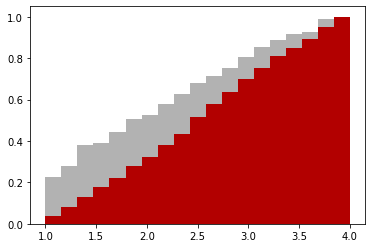

In [64]:
# nl_std = np.std(nl_ca1.mean(axis=0),axis=-1)
# l_std = np.std(l_ca1.mean(axis=0),axis=-1)
bins = np.linspace(1,4,num=20)
fig,ax = plt.subplots()
ax.hist(nl_std,fill=True,bins=bins,cumulative=True, density=True, color='red')
ax.hist(l_std, fill=True,bins=bins, color='black',alpha=.3,cumulative=True, density=True)



In [65]:
# add learning with a gain parameter

# uniform gain parameter vs 0 gain

# gain parameter depends on proximity to reward - aka dopamine

# homeostatic plasticity

# look for prediction of more out of field firing in the absence of LTP

# ask for example entorhinal 

# prediction that CA3 inactivated animals won't over represent reward?


In [67]:
a= np.arange(0,10)
print(np.argsort(a))

[0 1 2 3 4 5 6 7 8 9]
